<a href="https://colab.research.google.com/github/Buki81/Buki81-Buki81-Algorithms_GU_python_2180-16.02.2022-/blob/master/Tkachev_Georgii/forest__zigzag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключаем гугл-диск

In [1]:
from google.colab import drive, output
drive.mount('/content/drive')
output.clear()

Импортируем библиотеки

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from shapely import geometry
%matplotlib inline

# Загружаем изображение, создаем границы и точки посадки саженцев

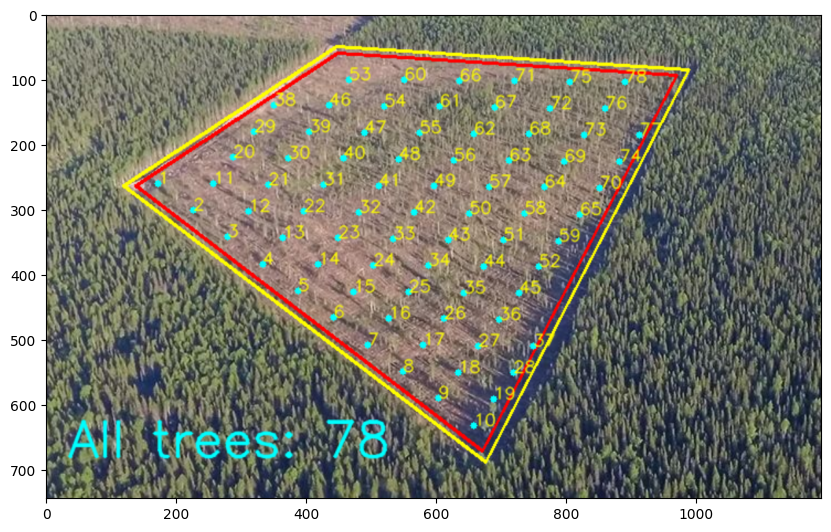

In [29]:
img_path = '/content/drive/MyDrive/AI/Forest_Robot/woodland.jpg'
img = cv2.imread(img_path)
img0 = cv2.imread(img_path)
img1 = cv2.imread(img_path)
h, w, _ =  img.shape

# Внешние границы участка
out_polygon = np.array([[70, 155], [263, 29], [582, 50], [398, 405]])
coords = out_polygon.tolist()
# Закрытые участки для посадки внутри внешних границ
in_polygon1 = np.array([[124, 159], [164, 140], [216, 122], [170, 159]]) # Левый верх
in_polygon2 = np.array([[323, 222], [350, 284], [424, 229], [417, 203], [349, 202]]) # Левый низ
in_polygon3 = np.array([[406, 62], [464, 92], [481, 96], [415,118], [326,123]]) # Правый
# Словарь всех участков
poly_dic = {
    'out': (out_polygon, out_polygon.tolist(), 0.02, -1),
    #'in_01': (in_polygon1, in_polygon1.tolist(), 0.02, 1),
    #'in_02': (in_polygon2, in_polygon2.tolist(), 0.02, 1),
    #'in_03': (in_polygon3, in_polygon3.tolist(), 0.02, 1),
    }

x = [i for i in range(0, 600, 30)]
y = [i for i in range(0, 600, 40)]

xs = [i[0] for i in coords]
ys = [i[1] for i in coords]
x_center = 0.5 * min(xs) + 0.5 * max(xs)
y_center = 0.5 * min(ys) + 0.5 * max(ys)
xy_center = (x_center,  y_center)

point_dic = {}
lst_points = []
exceptions = []
for i in x:
    for k in y:
        coordinates = (i, k)
        lst_points.append(coordinates)

def rotate(p, origin, degrees):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

degrees=-52.5
new_points = rotate(lst_points , xy_center, degrees)
for i, n in enumerate(new_points):
    coord = (int(n[0]), int(n[1]))
    point_dic[i] = coord


def change_polygon(coords, factor, change):
    coords = coords
    lines = [[coords[i-1], coords[i]] for i in range(len(coords))]

    factor = factor

    # code from nathan
    xs = [i[0] for i in coords]
    ys = [i[1] for i in coords]
    x_center = 0.5 * min(xs) + 0.5 * max(xs)
    y_center = 0.5 * min(ys) + 0.5 * max(ys)

    min_corner = geometry.Point(min(xs), min(ys))
    max_corner = geometry.Point(max(xs), max(ys))
    center = geometry.Point(x_center, y_center)
    shrink_distance = center.distance(min_corner)*factor
    change = change # Минус - уменьшение, плюс - увеличение polygon

    my_polygon = geometry.Polygon(coords)
    my_polygon_shrunken = my_polygon.buffer(change * shrink_distance)

    x, y = my_polygon_shrunken.exterior.xy
    arr1 = np.rint(x).astype(int)
    arr2 = np.rint(y).astype(int)
    lst_new = []
    for i in range(len(x)-1):
        res = [int(x[i]), int(y[i])]
        lst_new.append(res)
    lst = np.array(lst_new)

    return lst

poly_change = {}
for i in poly_dic:
    if i == 'out':
        lst = change_polygon(poly_dic[i][1], poly_dic[i][2], poly_dic[i][3])
        cv2.polylines(img,[poly_dic[i][0]],True,(0,255,255),2)
        cv2.polylines(img,[lst],True,(0, 0, 255),2)
        poly_change[i] = lst

    elif i.split('_')[0] == 'in':
        lst = change_polygon(poly_dic[i][1], poly_dic[i][2], poly_dic[i][3])
        cv2.polylines(img,[poly_dic[i][0]],True,(0,255,255),2)
        cv2.polylines(img,[lst],True,(0, 0, 255),2)
        poly_change[i] = lst

save_point = {}
save_point_lst = []
out_point_lst = []

n_point = 0
for point in point_dic:
    result = cv2.pointPolygonTest(np.array(poly_change['out']), tuple(point_dic[point]), measureDist=False)
    if result == 1: # and result2 == -1 and result2 == -1 and result3 == -1:

        n_point += 1
        point_str = '{:01}'.format(n_point)
        save_point[int(point_str)] = point_dic[point]

        if int(point_str) not in exceptions:
            save_point_lst.append(point_dic[point])

            img = cv2.circle(img, point_dic[point], 3, (255, 255, 0), -1)

            font = cv2.FONT_HERSHEY_SIMPLEX
            org = point_dic[point] #(50, 50)
            fontScale = 0.5
            color = (0, 255, 255)
            thickness = 1
            img = cv2.putText(img, point_str, org, font, fontScale, color, thickness, cv2.LINE_AA)

font = cv2.FONT_HERSHEY_SIMPLEX
org = (20, 400)
fontScale = 1.5
color = (255, 255, 0)
thickness = 2

txt = f'All trees: {len(save_point_lst)}'
img = cv2.putText(img, txt, org, font, fontScale, color, thickness, cv2.LINE_AA)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
a = 1.7
img = cv2.resize(img, (int(w*a), int(h*a)))
plt.figure(figsize=(10, 7))
plt.imshow(img)
plt.show()

Строим маршрут, как должен ехать трактор
# Паралелльно и перпендикулярно

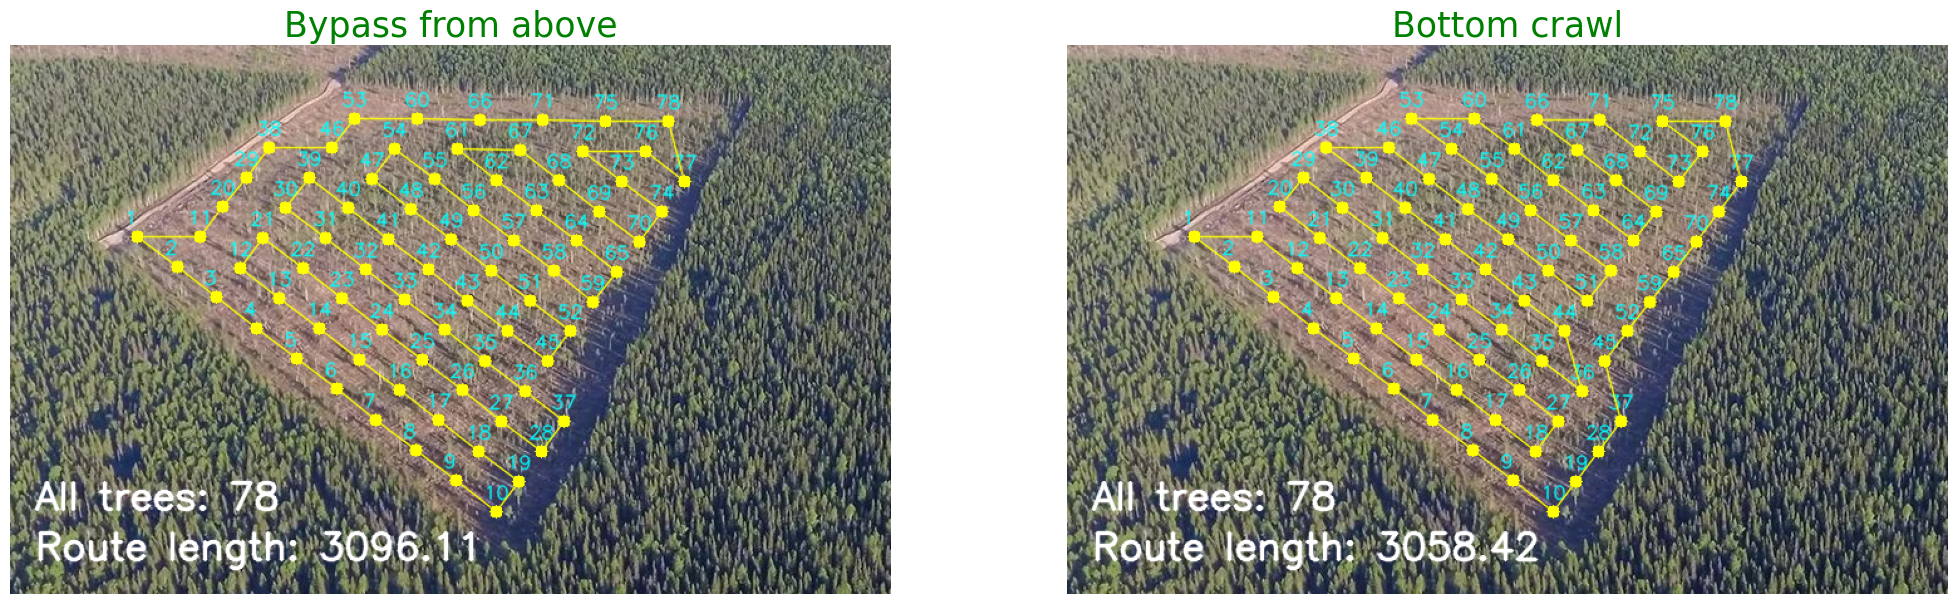

In [30]:
coord_dic = save_point
lst = []
a = set()
for p in range(2, len(coord_dic)+1):
    dist_trees = np.linalg.norm(np.array(coord_dic[2]) - np.array(coord_dic[1]))
    dist_p = np.linalg.norm(np.array(coord_dic[p-1]) - np.array(coord_dic[p]))
    if p == len(coord_dic) and abs(dist_trees - dist_p) < 2:
        a.add(p-1)
        a.add(p)
        a = list(a)
        a.sort()
        lst.append(a)
        a = set()
    elif abs(dist_trees - dist_p) < 2:
        a.add(p-1)
        a.add(p)
    elif abs(dist_trees - dist_p) > 2:
        a = list(a)
        a.sort()
        lst.append(a)
        a = set()
        if p == len(coord_dic):
            a.add(p)
            a = list(a)
            lst.append(a)
            a = set()

new_lst = []
a = set()
for p in range(2, len(coord_dic)+1):
    dist_trees = np.linalg.norm(np.array(coord_dic[2]) - np.array(coord_dic[1]))
    dist_p = np.linalg.norm(np.array(coord_dic[p-1]) - np.array(coord_dic[p]))
    if p == len(coord_dic) and abs(dist_trees - dist_p) < 2:
        a.add(p-1)
        a.add(p)
        a = list(a)
        a.sort()
        new_lst.append(a)
        a = set()
    elif abs(dist_trees - dist_p) < 2:
        a.add(p-1)
        a.add(p)
    elif abs(dist_trees - dist_p) > 2:
        a = list(a)
        a.sort()
        new_lst.append(a)
        a = set()
        if p == len(coord_dic):
            a.add(p)
            a = list(a)
            new_lst.append(a)
            a = set()

# Начинаем сверху
path_top = []
for i in range(len(lst)):
    path_top.append(lst[i][0])
for j in range(len(lst)):
    if (-1-j)%2 == False:
        lst[-1-j].sort(reverse=True)
    elif len(lst)%2 == True:
        lst[0].sort(reverse=True)
for j in range(len(lst)):
    for i in lst[-1-j]:
        if i not in path_top:
            path_top.append(i)

# Начинаем снизу
path_low = []
for y in range(len(new_lst)):
    if y == 0:
        path_low = [new_lst[0][n] for n in range(len(new_lst[0]))]
    elif new_lst[y][-1] not in path_low:
        path_low.append(new_lst[y][-1])
for j in range(len(new_lst)):
    if (-1-j)%2 == True:
        new_lst[-1-j].sort(reverse=True)
    elif len(new_lst)%2 == False:
        new_lst[0].sort(reverse=True)
for j in range(len(new_lst)):
    for y in new_lst[-1-j]:
        if y not in path_low:
            path_low.append(y)

def path_graf(path_bot, img):
    #global img
    distance = 0
    for k in range(len(path_bot)):
        cord_p = coord_dic[path_bot[k]]
        img = cv2.circle(img, cord_p, 5, (255, 255, 0), -1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        org = (cord_p[0]-10, cord_p[1]-10)
        fontScale = 0.5
        color = (0, 255, 255)
        thickness = 1
        img = cv2.putText(img, f'{path_bot[k]}', org, font, fontScale, color, thickness, cv2.LINE_AA)
        pt1, pt2 = coord_dic[path_bot[k-1]], coord_dic[path_bot[k]]
        img = cv2.line(img, pt1, pt2, (255, 255, 0), 1, cv2.LINE_AA)
        distance += np.sum([np.linalg.norm(np.array(pt1) - np.array(pt2))])


    img = cv2.putText(img, f'All trees: {len(path_bot)}',\
                      (20, 370), font, 1.0, (255, 255, 255), 2, cv2.LINE_AA)
    img = cv2.putText(img, f'Route length: {round(distance, 2)}',\
                      (20, 410), font, 1.0, (255, 255, 255), 2, cv2.LINE_AA)

plt.subplots(1, 2, figsize=(25, 15))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title(label="Bypass from above", fontsize=25, color="green")
path_graf(path_top, img0)
plt.imshow(img0)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title(label="Bottom crawl", fontsize=25, color="green")
path_graf(path_low, img1)
plt.imshow(img1)
plt.show()
